<a href="https://colab.research.google.com/github/Luke-Dev-Tech/Essentials-And-Applications-of-artificial-intelligence/blob/main/EAI_(Recycling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1] Kaggle Json

In [ ]:
from google.colab import drive
import shutil
import os

drive.mount('/content/drive')
kaggle_json = "/content/drive/My Drive/UWE Projects/EAI/kaggle.json"

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
shutil.copyfile(kaggle_json, os.path.expanduser('~/.kaggle/kaggle.json'))
!chmod 600 ~/.kaggle/kaggle.json

# [2] Modular Section

In [ ]:
!mkdir -p modular

## [2.1] kaggle_data.py

In [ ]:
%%writefile modular/kaggle_data.py
import os
import zipfile
from pathlib import Path
import subprocess

def kaggleDataImport(dataset_name: str):
    """
    dataset_name example:
    'feyzazkefe/trashnet'
    """

    data_path = Path("data")
    data_path.mkdir(parents=True, exist_ok=True)

    zip_name = dataset_name.split("/")[-1] + ".zip"
    zip_path = data_path / zip_name

    # ---------------- Download ----------------
    if not zip_path.exists():
        print(f"[Info] Downloading {dataset_name} ...")
        subprocess.run(
            [
                "kaggle",
                "datasets",
                "download",
                "-d",
                dataset_name,
                "-p",
                str(data_path)
            ],
            check=True
        )
    else:
        print("[Success] Zip already exists")

    # ---------------- Unzip ----------------
    print("[Info] Extracting dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_path)

    # ---------------- Detect extracted folder ----------------
    extracted_items = [
        p for p in data_path.iterdir()
        if p.is_dir() and p.name != "__MACOSX"
    ]

    if len(extracted_items) == 1:
        dataset_dir = extracted_items[0]
    else:
        # Multiple folders → choose most recent
        dataset_dir = max(extracted_items, key=lambda p: p.stat().st_mtime)

    print("[Success] Dataset ready at:", dataset_dir)

    # ---------------- Cleanup ----------------
    os.remove(zip_path)

    return dataset_dir

Writing modular/kaggle_data.py


## [2.2] data_setup.py

In [ ]:
%%writefile modular/data_setup.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import os

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    data_dir: str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int,
    test_size: float = 0.2,
    random_state: int = 42,
    num_workers: int = NUM_WORKERS
):
    train_data = datasets.ImageFolder(root=data_dir, transform=train_transform)
    test_data = datasets.ImageFolder(root=data_dir, transform=test_transform)

    class_names = train_data.classes
    indices = list(range(len(train_data)))

    train_idx, test_idx = train_test_split(
        indices,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=train_data.targets
    )

    train_dataset = Subset(train_data, train_idx)
    test_dataset = Subset(test_data, test_idx)

    print(f"[INFO] Total images: {len(train_data)}")
    print(f"[INFO] Training images: {len(train_dataset)}")
    print(f"[INFO] Testing images: {len(test_dataset)}")

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return (train_dataloader, test_dataloader, class_names, train_dataset, test_dataset, train_idx, test_idx)

Writing modular/data_setup.py


## [2.3] engine.py

In [ ]:
%%writefile modular/engine.py

import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# Main Method (1): Train Step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fun: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_pred = model(X)

    # Calculate and Accumulate the loss
    loss = loss_fun(y_pred, y)
    train_loss += loss.item()

    # Optimizer Zero
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # opitmizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric acorss all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

# Main Method (2): Test Step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fun: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device
              ):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fun(y_pred, y)
      test_loss += loss.item()
      test_acc += (torch.argmax(torch.softmax(y_pred, dim=1), dim=1) == y).sum().item()/len(y_pred)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

# Main Method (3): Initiate
def initiate_train_test(model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fun: torch.nn.Module,
           epochs: int,
           device: torch.device) -> Dict[str, List]:
  """
  :
  :return: Retrun a dictionary containing Training loss, training acc, test loss and test acc.
  This initiate training and testing processes by using the data loaded by dataloader.

  """
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fun=loss_fun,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fun=loss_fun,
                                    optimizer=optimizer,
                                    device=device)

    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results



Writing modular/engine.py


## [2.4] utlis.py

In [ ]:
%%writefile modular/utils.py

import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name:str):
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(), f=model_save_path)


Writing modular/utils.py


## [2.5] pred_and_plot_img.py

In [ ]:
%%writefile modular/pred_and_plot_img.py
from typing import List, Tuple
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def pred_and_plot_img(
    model: torch.nn.Module,
    image_path: str,
    class_name: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device
):
    # Load image
    img_pil = Image.open(image_path).convert("RGB")

    # Use provided transform or default VGG-Face transform
    if transform is None:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.ToTensor(),
            transforms.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )
        ])

    model.to(device)
    model.eval()

    with torch.inference_mode():
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        pred_prob = probs.max().item()

    actual_label = Path(image_path).parent.name
    pred_label = class_name[pred_idx]

    plt.figure(figsize=(5, 5))
    plt.imshow(img_pil)
    plt.title(
        f"Actual: {actual_label} | Pred: {pred_label} | Prob: {pred_prob:.3f}"
    )
    plt.axis("off")


Writing modular/pred_and_plot_img.py


# [3] Pipeline

In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchvision
from modular import kaggle_data, data_setup, engine, utils, pred_and_plot_img
from timeit import default_timer as timer


if __name__ == "__main__":
  #====================Device Setup=============================
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  #=============================================================
  # Kaggle Data Import
  kaggle_data.kaggleDataImport('feyzazkefe/trashnet')
  #=================Attribute Section===========================
  # NUM_EPOCHS = 30
  BATCH_SIZE = 32
  # HIDDEN_UNITS = 10
  # LEARNING_RATE = 0.0005
  data_dir = 'data/dataset-resized'
  #=============================================================
  # Data_setup
  train_transform = transforms.Compose([
      transforms.Resize((260, 260)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(10),
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )
  ])

  test_transform = transforms.Compose([
      transforms.Resize((260, 260)),
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )
  ])

  train_dataloader, test_dataloader, class_names , train_dataset, test_dataset, train_index, test_index = data_setup.create_dataloaders(
    data_dir=data_dir,
    train_transform=train_transform,
    test_transform=test_transform,
    batch_size=BATCH_SIZE,
    test_size=0.2  # 80/20 split
  )
  #=============================================================
  # Engine
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  #=======================EfficientNet B2============================#
  #=========================={PHASE 1}===============================#
  # PHASE (1): Backbone
  # EPOCH - 5
  # LR - 0.001
  # Backbone
  # New optimizer [Mandatory]
  # Weight decay [ADDed]
  #
  #=============================================================
  weigths = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weigths).to(device)
  #=============================================================
  num_classes = len(class_names)
  model.classifier = torch.nn.Sequential(
      torch.nn.Dropout(p=0.2, inplace=True),
      torch.nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  ).to(device)

  for param in model.features.parameters():
      param.requires_grad = False
  #=============================================================
  #===============Loss function and Optimizer===================
  loss_fun = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
  #=============================================================
  print("======== PHASE 1: Training ==========")
  start_time = timer()
  engine.initiate_train_test(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fun=loss_fun,
    optimizer=optimizer,
    epochs=5,
    device=device
  )
  end_time = timer()
  print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
  print("=======================================")
  #=================Utils for saving models=====================
  utils.save_model(
      model=model,
      target_dir='models',
      model_name=f'Recycle_Model_.pth'
  )
  #=============================================================


[Info] Downloading feyzazkefe/trashnet ...
[Info] Extracting dataset...
[Success] Dataset ready at: data/dataset-resized
[INFO] Total images: 2527
[INFO] Training images: 2021
[INFO] Testing images: 506
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 79.2MB/s]


======== PHASE 1: Training ==========


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3056 | train_acc: 0.5538 | test_loss: 0.9732 | test_acc: 0.7452
Epoch: 2 | train_loss: 0.9107 | train_acc: 0.7187 | test_loss: 0.7923 | test_acc: 0.7803
Epoch: 3 | train_loss: 0.7598 | train_acc: 0.7508 | test_loss: 0.6939 | test_acc: 0.8155
Epoch: 4 | train_loss: 0.6934 | train_acc: 0.7773 | test_loss: 0.6530 | test_acc: 0.8116
Epoch: 5 | train_loss: 0.6563 | train_acc: 0.7804 | test_loss: 0.6304 | test_acc: 0.7999
[INFO] Total training time: 79.936 seconds
[INFO] Saving model to: models/Recycle_Model_.pth


# [4] Random 3 IMG Testing

In [ ]:

from typing import List, Tuple
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image # Import Image for PIL operations
from pathlib import Path # Import Path to handle paths

def pred_and_plot_img(model: torch.nn.Module,
                     image_path: str,
                     class_names: List[str],
                     image_size: Tuple[int, int] = (224, 224),
                     transform: torchvision.transforms = None,
                     device: torch.device = "cpu"):

    # 1. Load and prepare image
    img_pil = Image.open(image_path).convert("RGB")

    if transform is not None:
        img_transform = transform
    else:
        img_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        ])

    # 2. Prediction logic
    model.to(device)
    model.eval()
    with torch.inference_mode():
        # Move transformed image to device
        transformed_img = img_transform(img_pil).unsqueeze(dim=0).to(device)
        logits = model(transformed_img)

        probs = torch.softmax(logits, dim=1)
        pred_label_idx = torch.argmax(probs, dim=1).item()
        pred_class = class_names[pred_label_idx]

    # 3. Extract actual label safely
    # This assumes your directory is: data_dir/class_name/image.jpg
    actual_label = Path(image_path).parent.name

    # 4. Plotting
    plt.figure(figsize=(6, 5))
    plt.imshow(img_pil)

    # Color code the title: Green for correct, Red for wrong
    title_color = "g" if pred_class == actual_label else "r"

    plt.title(f"Actual: {actual_label} | Pred: {pred_class}\nProb: {probs.max():.3f}",
              color=title_color)
    plt.axis(False)

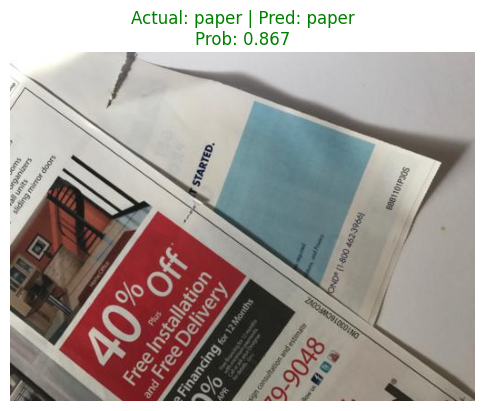

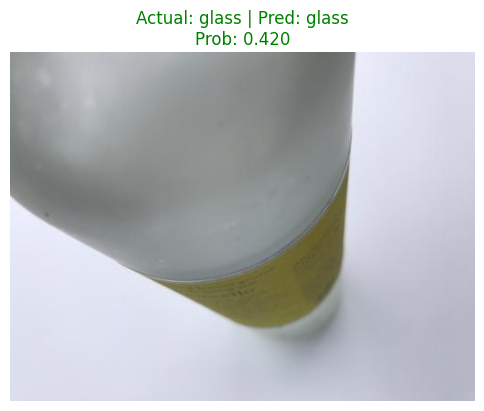

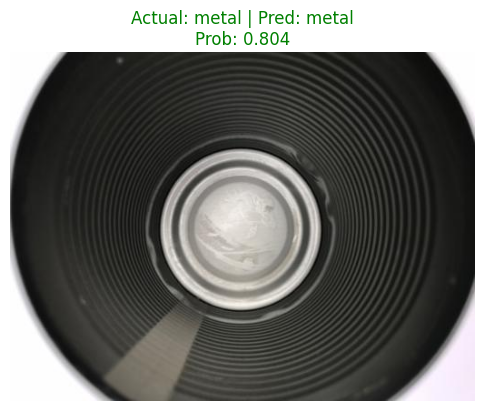

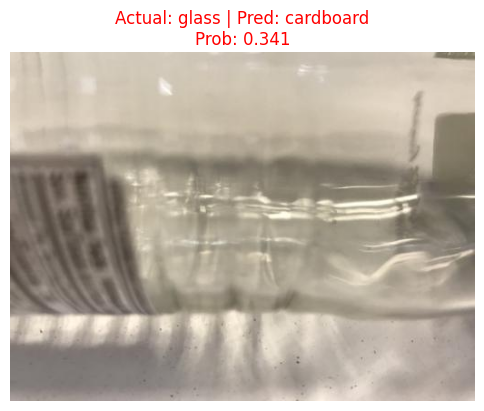

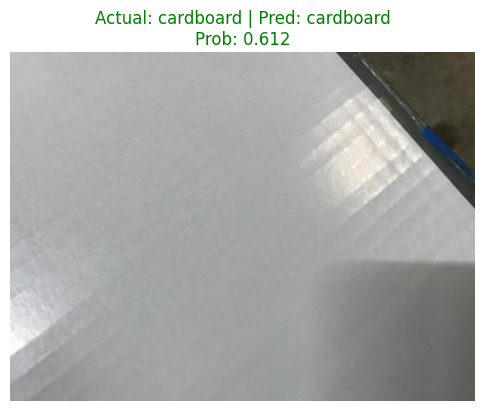

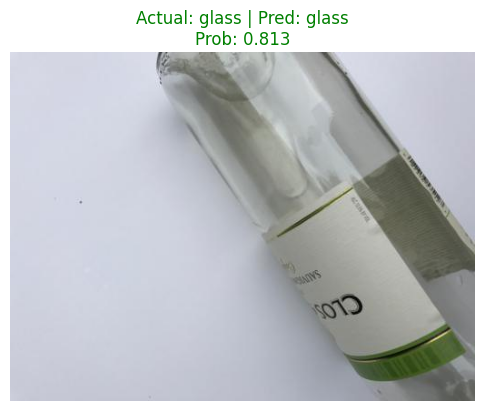

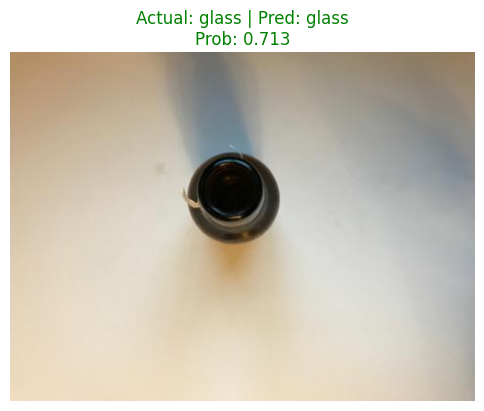

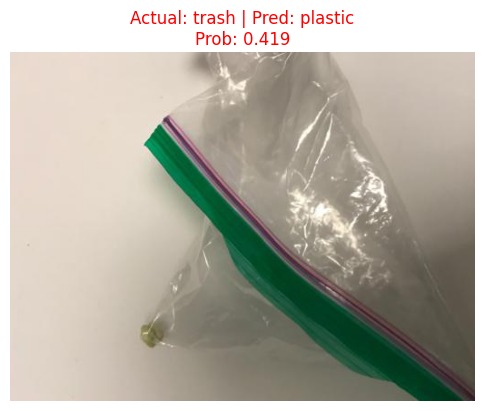

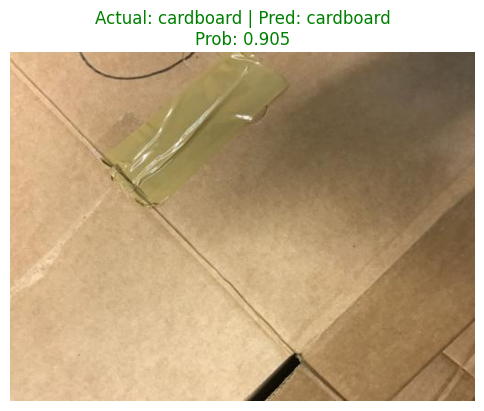

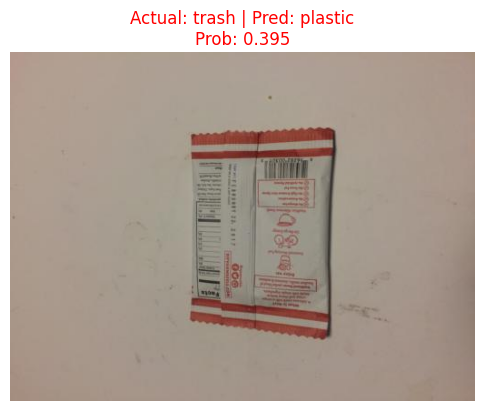

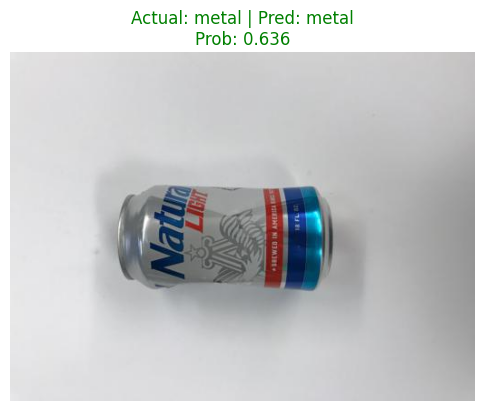

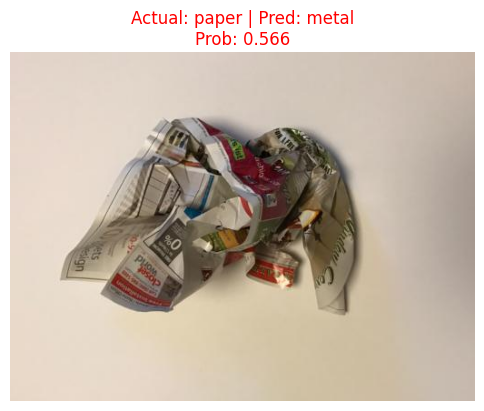

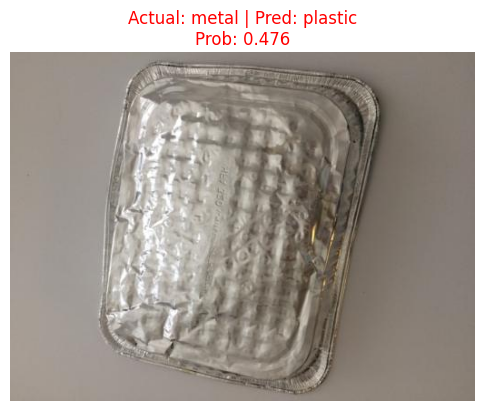

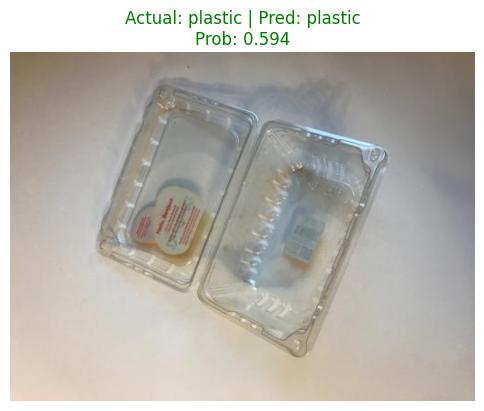

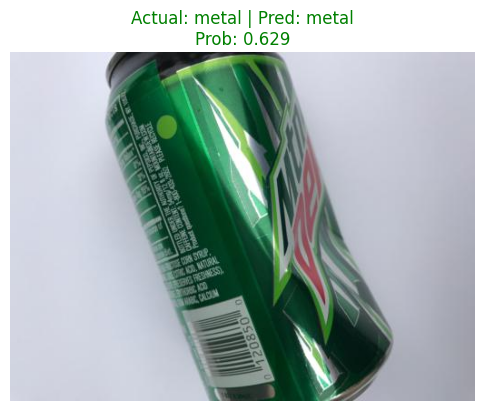

In [ ]:
import random
# Instead of globbing the whole folder, use the indices from your split
# Assuming 'test_dataset' is what was returned by your create_dataloaders function
num_images_to_plot = 15
for _ in range(num_images_to_plot):
    # Get a random index from the test_dataset
    random_idx = random.randint(0, len(test_index)-1)

    # Get the image path from the underlying ImageFolder samples list
    # test_dataset.indices maps the subset index back to the original index
    original_idx = test_dataset.indices[random_idx]
    image_path, _ = test_dataset.dataset.samples[original_idx]

    pred_and_plot_img(
        model=model,
        image_path=image_path,
        class_names=class_names,
        transform=test_transform,
        device=device
    )

# [5] Custom IMG TESTing

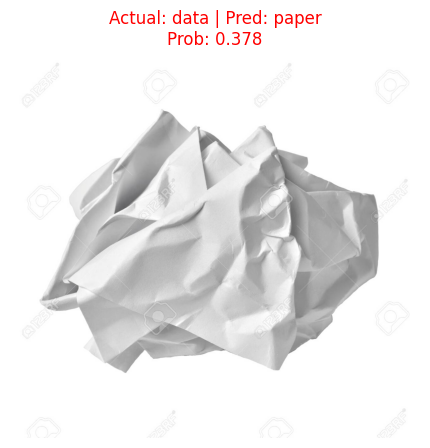

In [ ]:
import requests
from pathlib import Path
import random

def custom_img_testing(link: str):
  custom_img_path = Path(f'data/custom_img_{round(random.random(), 3)}.jpg')

  if not custom_img_path.is_file():
    print(f"Downloading custom image ... ")
    with open(custom_img_path, "wb") as f:
      request = requests.get(link)
      f.write(request.content)
  else:
    print(f"{custom_img_path} already exists")

  return custom_img_path


pred_and_plot_img(
    model=model,
    image_path=custom_img_testing(link="https://previews.123rf.com/images/picsfive/picsfive2001/picsfive200100370/138798094-close-up-of-a-paper-ball-trash-on-white-background.jpg"),
    class_names=class_names,
    transform=test_transform,
    device=device
)



In [ ]:
!pip install seaborn scikit-learn

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 79.84%


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[ 70   0   0   8   1   2]
 [  1  80   8   2   9   0]
 [  0   8  71   0   3   0]
 [  6   0   8 100   3   2]
 [  0  12   8   4  70   3]
 [  1   0   7   4   2  13]]


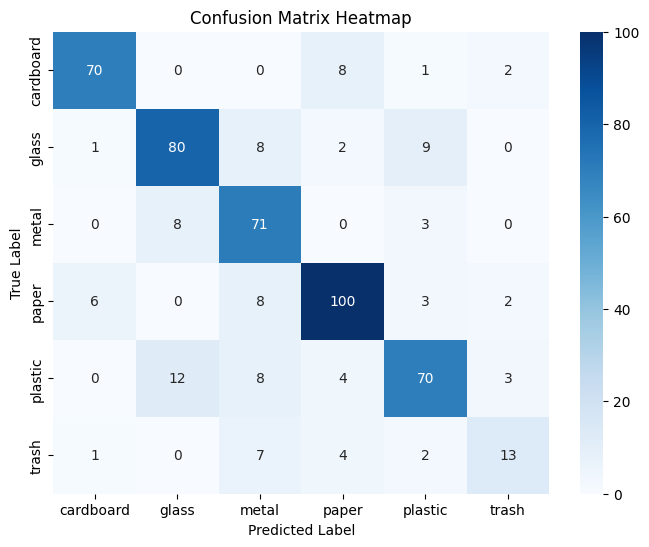

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.90      0.86      0.88        81
       glass       0.80      0.80      0.80       100
       metal       0.70      0.87      0.77        82
       paper       0.85      0.84      0.84       119
     plastic       0.80      0.72      0.76        97
       trash       0.65      0.48      0.55        27

    accuracy                           0.80       506
   macro avg       0.78      0.76      0.77       506
weighted avg       0.80      0.80      0.80       506



In [ ]:
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\nOverall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-score: {f1:.4f}")


Overall Precision: 0.8010
Overall Recall: 0.7984
Overall F1-score: 0.7972


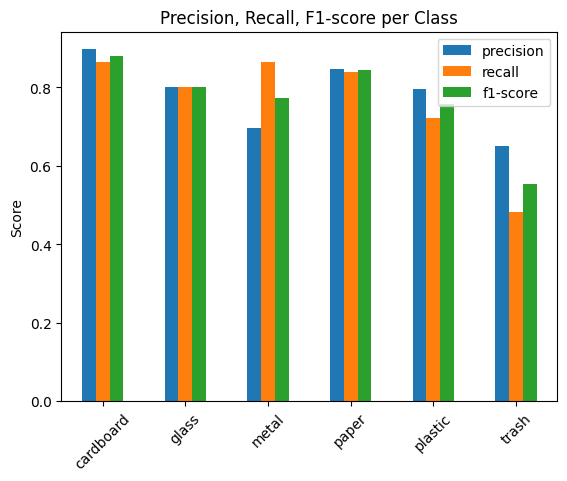

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(all_labels, all_preds,
                               target_names=class_names,
                               output_dict=True)

df = pd.DataFrame(report).transpose()

metrics = df.loc[class_names][["precision", "recall", "f1-score"]]

metrics.plot(kind="bar")
plt.title("Precision, Recall, F1-score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()